<a href="https://colab.research.google.com/github/Tanzil748/Micro-credential/blob/main/MachineLearning(KNN_RandomForest).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Goal: Find out the likelihood of patients being readmitted into the hospital. If readmitted, determine if it happens within a month (30 days) or after that alotted time.

In [1]:
#importing libraries I plan to use in this project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Moved all my data to a dataframe called 'df'
df = pd.read_csv('https://raw.githubusercontent.com/niteen11/cuny_lagcc_micro_credential_data_analytics/main/Track%20A/Unit%204%20-%20Machine%20Learning%20and%20Modeling%20Techniques/Dataset/diabetic_data.csv')
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [3]:
#Got rid of columns that were irrelevant to our goal or those that had too many null values.
df.drop(['weight','encounter_id','admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','A1Cresult','max_glu_serum'], inplace=True, axis=1)
df

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),1,41,0,1,0,0,0,1,No,No,NO
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,9,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,6,No,Yes,NO
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,7,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,5,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),3,51,0,16,0,0,0,9,Ch,Yes,>30
101762,AfricanAmerican,Female,[80-90),5,33,3,18,0,0,1,9,No,Yes,NO
101763,Caucasian,Male,[70-80),1,53,0,9,1,0,0,13,Ch,Yes,NO
101764,Caucasian,Female,[80-90),10,45,2,21,0,0,1,9,Ch,Yes,NO


In [4]:
#General overview of data
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [5]:
#Find out all the unique values in race column.
df.race.unique

<bound method Series.unique of 0               Caucasian
1               Caucasian
2         AfricanAmerican
3               Caucasian
4               Caucasian
               ...       
101761    AfricanAmerican
101762    AfricanAmerican
101763          Caucasian
101764          Caucasian
101765          Caucasian
Name: race, Length: 101766, dtype: object>

In [6]:
#Replaced all these unique values with numerical values in a dictionary. These keys and values will later help me run KNN and RandomForest models more easily.
race_dict = {'?':0, 'AfricanAmerican':1, 'Asian':2, 'Caucasian':3, 'Hispanic':4, 'Other':5}
race_dict

{'?': 0,
 'AfricanAmerican': 1,
 'Asian': 2,
 'Caucasian': 3,
 'Hispanic': 4,
 'Other': 5}

In [7]:
#Replaced string values with integer values
df.race = [race_dict[item] for item in df.race] 
print(df)

        race  gender      age  ...  change  diabetesMed  readmitted
0          3  Female   [0-10)  ...      No           No          NO
1          3  Female  [10-20)  ...      Ch          Yes         >30
2          1  Female  [20-30)  ...      No          Yes          NO
3          3    Male  [30-40)  ...      Ch          Yes          NO
4          3    Male  [40-50)  ...      Ch          Yes          NO
...      ...     ...      ...  ...     ...          ...         ...
101761     1    Male  [70-80)  ...      Ch          Yes         >30
101762     1  Female  [80-90)  ...      No          Yes          NO
101763     3    Male  [70-80)  ...      Ch          Yes          NO
101764     3  Female  [80-90)  ...      Ch          Yes          NO
101765     3    Male  [70-80)  ...      No           No          NO

[101766 rows x 14 columns]


In [8]:
#Assigned values to certain times. Makes it easier to track when patients were readmitted.
readmitted_dict = {'NO':0, '>30':1, '<30':2}
df.readmitted = [readmitted_dict[item] for item in df.readmitted]
change_dict = {'No':0, 'Ch':1}
df.change = [change_dict[item] for item in df.change] 
diabetesMed_dict = {'No':0, 'Yes':1}
df.diabetesMed = [diabetesMed_dict[item] for item in df.diabetesMed]
df

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted
0,3,Female,[0-10),1,41,0,1,0,0,0,1,0,0,0
1,3,Female,[10-20),3,59,0,18,0,0,0,9,1,1,1
2,1,Female,[20-30),2,11,5,13,2,0,1,6,0,1,0
3,3,Male,[30-40),2,44,1,16,0,0,0,7,1,1,0
4,3,Male,[40-50),1,51,0,8,0,0,0,5,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,Male,[70-80),3,51,0,16,0,0,0,9,1,1,1
101762,1,Female,[80-90),5,33,3,18,0,0,1,9,0,1,0
101763,3,Male,[70-80),1,53,0,9,1,0,0,13,1,1,0
101764,3,Female,[80-90),10,45,2,21,0,0,1,9,1,1,0


In [9]:
#Assigned values to patients genders.
gender_dict = {'Female':0, 'Male':1, 'Unknown/Invalid':2}
df.gender = [gender_dict[item] for item in df.gender] 
age_dict = {'[0-10)':0, '[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6, '[70-80)':7, '[80-90)':8, '[90-100)':9}
df.age = [age_dict[item] for item in df.age] 
df

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted
0,3,0,0,1,41,0,1,0,0,0,1,0,0,0
1,3,0,1,3,59,0,18,0,0,0,9,1,1,1
2,1,0,2,2,11,5,13,2,0,1,6,0,1,0
3,3,1,3,2,44,1,16,0,0,0,7,1,1,0
4,3,1,4,1,51,0,8,0,0,0,5,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,7,3,51,0,16,0,0,0,9,1,1,1
101762,1,0,8,5,33,3,18,0,0,1,9,0,1,0
101763,3,1,7,1,53,0,9,1,0,0,13,1,1,0
101764,3,0,8,10,45,2,21,0,0,1,9,1,1,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


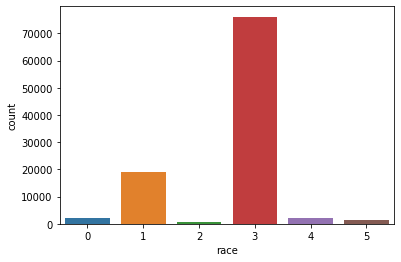

In [10]:
# The vast majority of patients in given data set are suprisingly Caucasian. African-Americans are the distant second.
sns.countplot(df['race'], label='Count')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


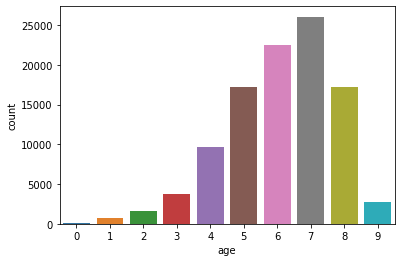

In [11]:
#We can see the vast majority of patients are between 50-90, with the greatest number being in the range of 70-80 years old.
sns.countplot(df['age'], label='Count')

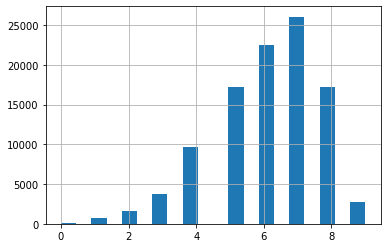

In [12]:
#Another graph displaying the age of patients in dataset.
df['age'].hist(bins=20)

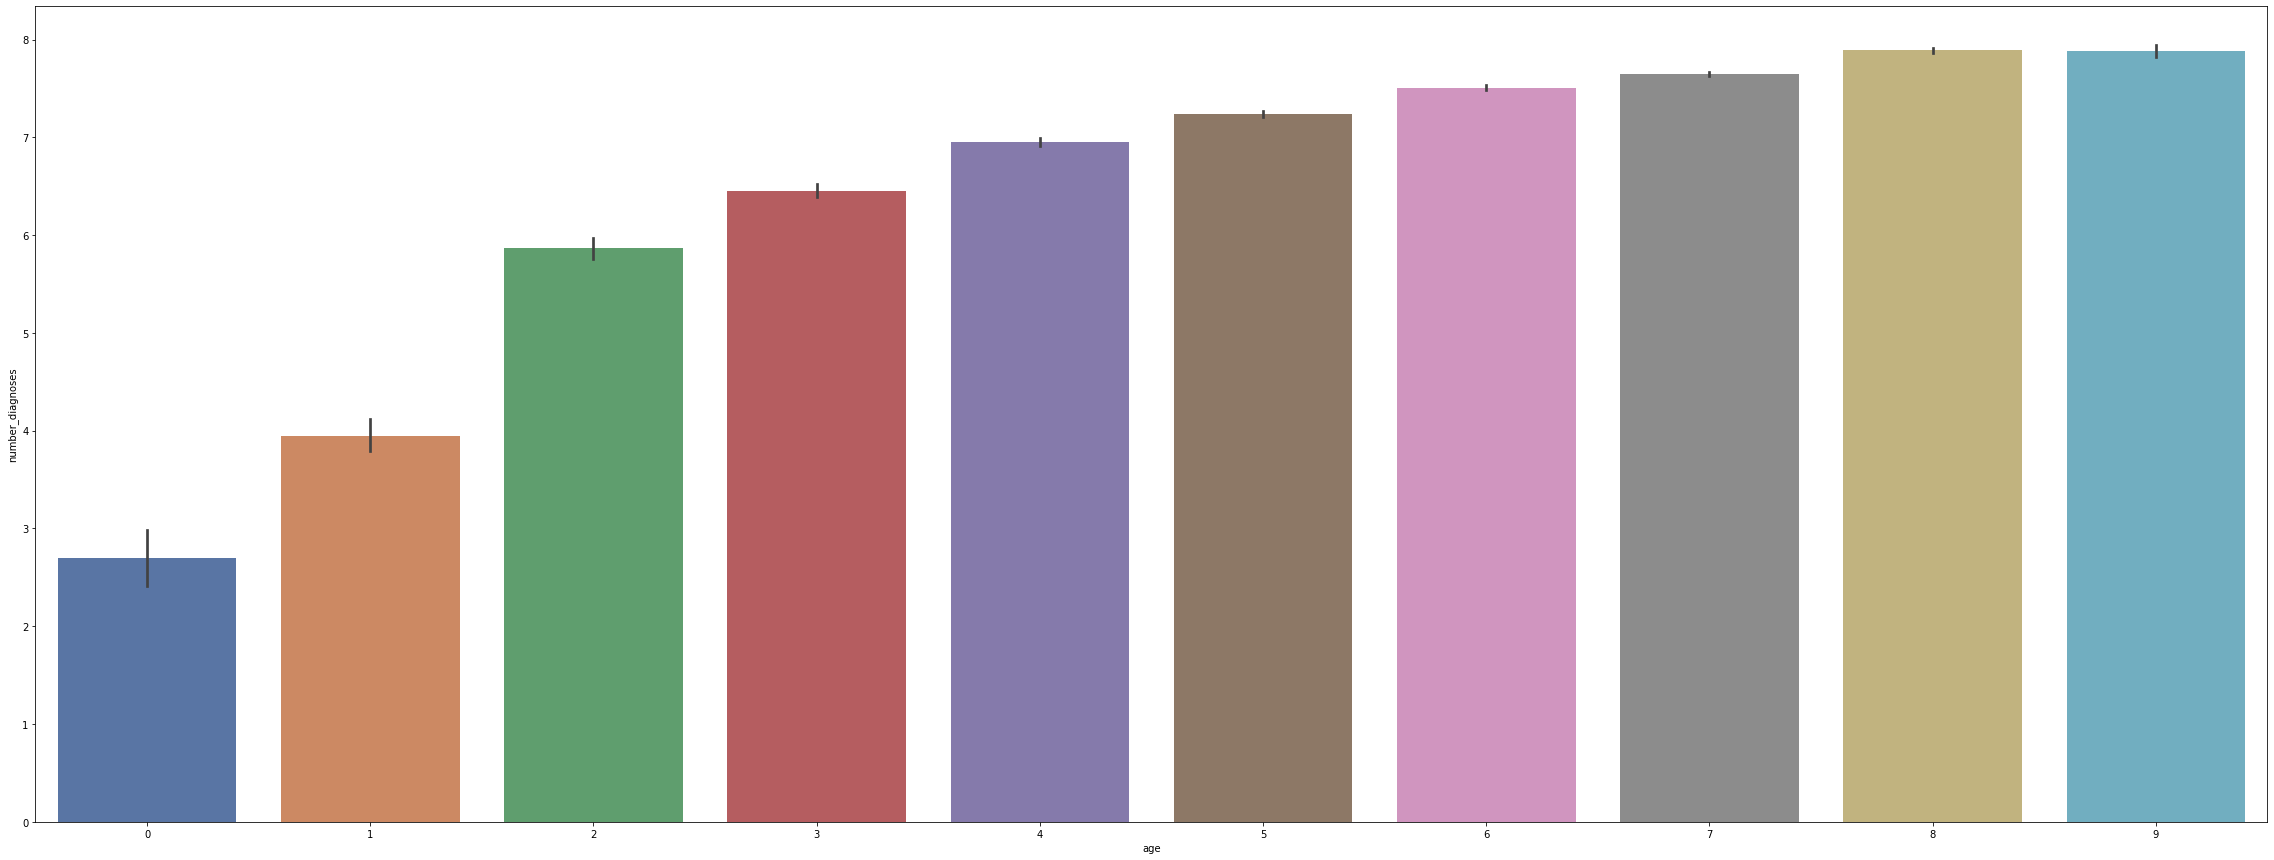

In [13]:
#The number of diagnoses per patient in relation to their age.
plt.figure(figsize=(40,15))
sns.barplot(x='age',y='number_diagnoses',data=df,palette='deep')

In [16]:
#The sklearn method, specifically the imported standard scaler, standardizes all my data values. This will prevent any data from being misrespresented. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('readmitted', axis=1)) #column drop 
StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_features = scaler.transform(df.drop('readmitted',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed
0,0.427557,-0.927397,-3.824600,-1.137649,-0.106517,-0.785398,-1.848268,-0.291461,-0.21262,-0.503276,-3.321596,-0.926591,-1.829868
1,0.427557,-0.927397,-3.197277,-0.467653,0.808384,-0.785398,0.243390,-0.291461,-0.21262,-0.503276,0.815784,1.079225,0.546488
2,-1.703706,-0.927397,-2.569954,-0.802651,-1.631351,2.145781,-0.371804,1.286748,-0.21262,0.288579,-0.735733,-0.926591,0.546488
3,0.427557,1.078031,-1.942632,-0.802651,0.045967,-0.199162,-0.002688,-0.291461,-0.21262,-0.503276,-0.218561,1.079225,0.546488
4,0.427557,1.078031,-1.315309,-1.137649,0.401761,-0.785398,-0.986997,-0.291461,-0.21262,-0.503276,-1.252906,1.079225,0.546488


In [17]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=319)

In [18]:
#dropped target column
x = df.drop(['readmitted'],axis=1)
x

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed
0,3,0,0,1,41,0,1,0,0,0,1,0,0
1,3,0,1,3,59,0,18,0,0,0,9,1,1
2,1,0,2,2,11,5,13,2,0,1,6,0,1
3,3,1,3,2,44,1,16,0,0,0,7,1,1
4,3,1,4,1,51,0,8,0,0,0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1,7,3,51,0,16,0,0,0,9,1,1
101762,1,0,8,5,33,3,18,0,0,1,9,0,1
101763,3,1,7,1,53,0,9,1,0,0,13,1,1
101764,3,0,8,10,45,2,21,0,0,1,9,1,1


In [19]:
# y is equal to target column
y = df['readmitted']

In [20]:
#importing a training data set so that the accurarcy can be measured
from sklearn.model_selection import train_test_split
#set test_size to 0.20 so that 80% of dataset can be used to test data set to make it fairly accurate
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 5)

In [21]:
#fit model with training data
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=319, p=2,
                     weights='uniform')

In [22]:
#tested model with testing data and assign predictions to the variable y_pred
y_pred = model.predict(x_test)

In [23]:
#the accuaracy of the KNN model I used is 50:50, not great odds
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5520782155841604


In [24]:
#the shape
x_train.shape

(81412, 13)

In [25]:
#importing RandomForest classifier 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#fit the training data with the RandomForest classifier
randomforest_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
randomforest_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
#testing model to see if it works with training set
y_predict_train = randomforest_classifier.predict(x_train)
cm = confusion_matrix(y_train, y_predict_train)

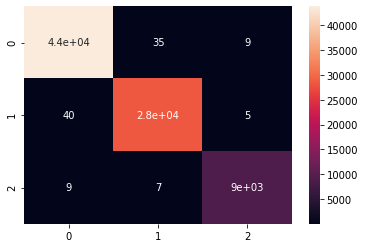

In [27]:
#model shows very little error
sns.heatmap(cm, annot=True)

In [28]:
#printed classification report, 100% accuracy
print(classification_report(y_train, y_predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43895
           1       1.00      1.00      1.00     28507
           2       1.00      1.00      1.00      9010

    accuracy                           1.00     81412
   macro avg       1.00      1.00      1.00     81412
weighted avg       1.00      1.00      1.00     81412



In [29]:
#testing model to see if it works with the testing data
y_predict = randomforest_classifier.predict(x_test)
cm = confusion_matrix(y_test, y_predict)

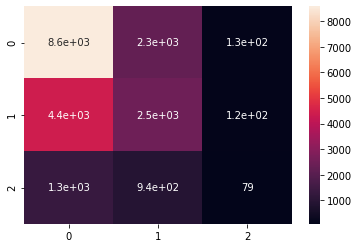

In [30]:
#the resulting model shows errors popping up, possiblly overfitted
sns.heatmap(cm, annot=True)

In [31]:
#printed classification report. discovered it was more accuarate to find out chances of a patient not being readmitted into health institution
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.60      0.78      0.68     10969
           1       0.44      0.36      0.39      7038
           2       0.25      0.03      0.06      2347

    accuracy                           0.55     20354
   macro avg       0.43      0.39      0.38     20354
weighted avg       0.50      0.55      0.51     20354

